In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import timm 
import torch.optim as optim
from utils.visualize_predictions import visualize_predictions
from utils.plot_training_validation import plot_training_validation
from utils.evaluation import evaluate_model
from utils.train import train_model

c:\Users\kubia\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# merged_dataset_dir = "../2_classes_merged_dataset"
merged_dataset_dir = "../3_classes_merged_dataset"

img_size = 224
batch_size = 32
num_workers = 8  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 42  
num_epochs = 5
torch.manual_seed(seed)

In [3]:
# -------------------------------
# 2) DEFINICJA TRANSFORMACJI DANYCH
# -------------------------------

# Transformacje dla zestawu treningowego
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(), 
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), 
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5),  # Normalizacja specyficzna dla ViT
                         std=(0.5, 0.5, 0.5))
])

# Transformacje dla zestawów walidacyjnego i testowego
test_val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5),
                         std=(0.5, 0.5, 0.5))
])


In [4]:
# -------------------------------
# 3) ŁADOWANIE I PODZIAŁ DANYCH
# -------------------------------

# Ładowanie całego zestawu danych za pomocą ImageFolder
full_dataset = datasets.ImageFolder(root=merged_dataset_dir, transform=train_transform)

# Definicja proporcji podziału
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Obliczanie rozmiarów poszczególnych zestawów
total_size = len(full_dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size  # Zapewnia, że wszystkie próbki są użyte

# Podział zestawu danych
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(seed)  # Zapewnia replikowalność podziału
)

# Zastosowanie różnych transformacji do zestawów walidacyjnego i testowego
# Ponieważ random_split zwraca obiekty Subset, redefiniujemy je z nowymi transformacjami
val_dataset = Subset(
    datasets.ImageFolder(root=merged_dataset_dir, transform=test_val_transform),
    val_dataset.indices
)

test_dataset = Subset(
    datasets.ImageFolder(root=merged_dataset_dir, transform=test_val_transform),
    test_dataset.indices
)

# Tworzenie DataLoaderów dla każdego podzbioru
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,  # Shuffle dla treningu
    num_workers=num_workers,
    pin_memory=True  # Przyspiesza transfer danych na GPU, jeśli używasz CUDA
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,  # Brak shuffle dla walidacji
    num_workers=num_workers,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,  # Brak shuffle dla testowania
    num_workers=num_workers,
    pin_memory=True
)

# Opcjonalnie: Wydrukowanie rozmiarów zestawów danych dla weryfikacji
print(f"\nTotal samples: {total_size}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Total samples: 4479
Training samples: 3583
Validation samples: 447
Test samples: 449


In [5]:
# -------------------------------
# 4) DEFINICJA MODELU VISION TRANSFORMER
# -------------------------------

# Inicjalizacja pretrenowanego modelu Vision Transformer
model = timm.create_model('vit_base_patch16_224', pretrained=True)

# Zamiana warstwy klasyfikacyjnej, aby dopasować liczbę klas w Twoim problemie
num_classes = len(full_dataset.classes)
model.head = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.head.in_features, num_classes)
).to(device)

# Przeniesienie modelu na urządzenie (GPU lub CPU)
model = model.to(device)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [7]:
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=num_epochs,
    gradient_clip=1.0,
    print_interval=10,
    save_dir="../saved_models/vit",
    save_best=True,
    save_every_epoch=False,
)

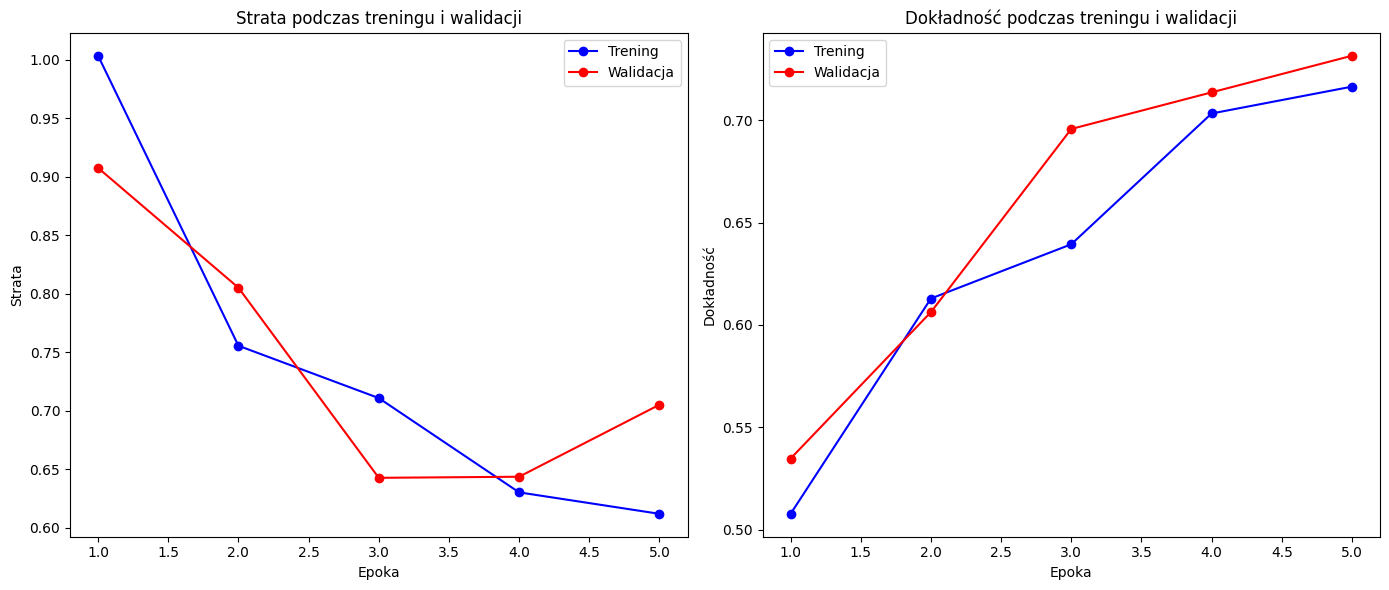

In [9]:
plot_training_validation(
    history["train_loss"], history["val_loss"], history["train_acc"], history["val_acc"]
)


Test Loss: 0.5758 | Test Acc: 0.7639

Raport klasyfikacji:
               precision    recall  f1-score   support

   BACTERIAL       0.63      0.93      0.75       150
      NORMAL       0.89      0.93      0.91       151
       VIRAL       0.88      0.43      0.57       148

    accuracy                           0.76       449
   macro avg       0.80      0.76      0.75       449
weighted avg       0.80      0.76      0.75       449



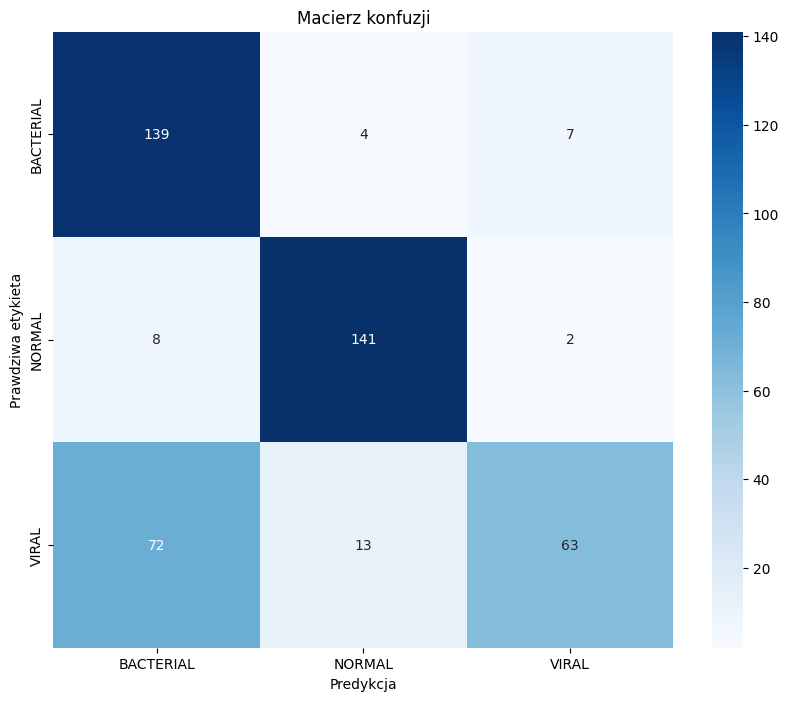

In [11]:
class_names = test_dataset.dataset.classes
evaluate_model(model, test_loader, criterion, device, class_names)

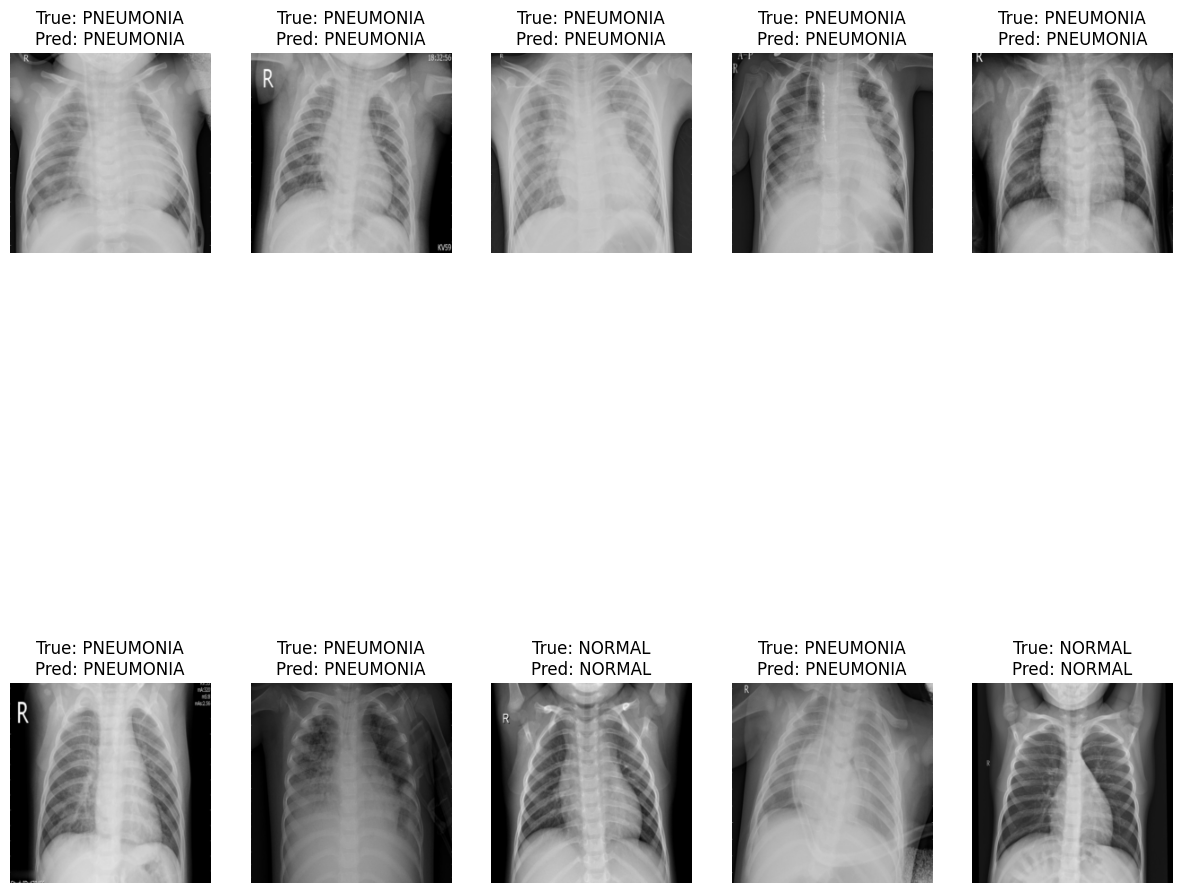

In [ ]:
visualize_predictions(model, test_loader, class_names, device, num_images=10)